<a href="https://colab.research.google.com/github/WesleyAldridge/MNIST-Number-Image-Classification/blob/master/MNIST_Number_Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MNIST Number Image Classification

![Image by Josef Steppan from Wikipedia](https://upload.wikimedia.org/wikipedia/commons/2/27/MnistExamples.png)

## In this notebook:

-- Used logistic regression with mean squared error loss and mini-batch stochastic gradient descent to train 10 classifiers to predict the label of numeric images as a number between 0 and 9.

-- Trained 10 classifiers that perform binary classification: Is the input image the digit i or is it a digit different from i? Each of the ten classifiers has an input layer consisting of 28 x 28 input neurons and an output layer consisting of a single output neuron. Here, the 28x28 input neurons represent the 28x28 pixels of the input images, and the single output neuron represents the binary classification for each classifier.

-- Implemented mini-batch stochastic gradient descent manually using only numpy (i.e. without the use of Tensorflow/Keras).

-- Used argmax to determine the classifier with the strongest output and declared the corresponding digit as output.

In [0]:
import numpy as np
from keras.datasets import mnist
from keras.utils import to_categorical
%matplotlib inline
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm # TQDM is a progress bar, purely cosmetic

#Part 1:
##Load the training and test data using Keras

In [0]:
# load train and test data
(train_images_original, train_labels_original), (test_images_original, test_labels_original) = mnist.load_data()

print(train_images_original.shape)
print(train_labels_original.shape)

(60000, 28, 28)
(60000,)


## Visualizing the input data:

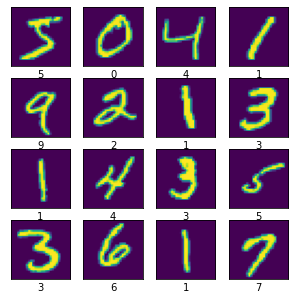

In [0]:
class_names = ['0', '1', '2', '3', '4',
               '5', '6', '7', '8', '9']

plt.figure(figsize=(5,5))
indices = np.random.choice(np.arange(60000), size=25, replace=False)
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images_original[i])
    plt.xlabel(class_names[train_labels_original[i]])
plt.show()

In [0]:
print(test_images_original.shape)
print(test_labels_original.shape)

(10000, 28, 28)
(10000,)


####Prepare data

In [0]:
# 60000 training images
# 10000 testing images
# 28*28 = 784 pixels per image/input neurons per classifier/features
# 1 output neuron per classifier

train_images = train_images_original.reshape((60000, 28 * 28))
train_images = train_images.astype('float32') / 255

test_images = test_images_original.reshape((10000, 28 * 28))
test_images = test_images.astype('float32') / 255

train_images.shape, test_images.shape

((60000, 784), (10000, 784))

In [0]:
# to_categorical: Converts a class vector (integers) to binary class matrix
# I.e. one-hot vector encoding
print(train_labels_original[0])
train_labels = to_categorical(train_labels_original)
print(train_labels[0])

test_labels = to_categorical(test_labels_original)

5
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


#Part 2:
### Implement mini-batch stochastic gradient descent manually, i.e. without the help of Keras/Tensorflow

### Logistic Regression
\begin{equation}
\hat{y} = a\left( \sum_{j=1}^n w_j x_j + b \right)
\end{equation}

\begin{equation}
z = \sum_{j=1}^n w_j x_j + b\,.
\end{equation}

\begin{equation}
x \quad \mapsto \quad z = w^T x + b = \sum_{j=1}^n w_j x_j + b \quad \mapsto \quad a = a(z).
\end{equation}

In [0]:
# input values (x) --> weights (w) --> net input function (wx) --> sigmoid activation function a(z) --> output

def net_input_function(x, w, b):
    # x.shape = (32, 784). 32 = batch_size. 784 = # of pixels
    # w.shape = (784,)
    # b.shape = (1,)
    z = np.dot(w.T, x.T) + b
    # z.shape = (32,)
    a = sigmoid(z) # activation function
    
    return a

###Sigmoid Function

\begin{equation}
\sigma(z) = \frac{1}{1+e^{-z}}.
\end{equation}

\begin{equation}
\sigma'(z)  = \sigma(z) \cdot (1-\sigma(z)) 
\end{equation}

In [0]:
def sigmoid(z):
    # Activation function
    return 1.0 / (1.0 + np.exp(-z))

###Squared error

Let $x\in\mathbb{R}^n$ be a feature vector and $y\in\{0,1\}$ its correct label. The squared error loss $\mathcal{L}_\mathrm{se}$ is defined by
\begin{equation}
\mathcal{L}_\mathrm{se} = \frac{1}{2} (a - y)^2\,.
\end{equation}
Its derivative with respect to $a$ is equal to 
\begin{equation}
{\mathrm{d} \mathcal{L}_\mathrm{se} \over \mathrm{d} a} = a - y.
\end{equation}

###Gradient of squared error

We have to compute the partial derivatives of the loss functions with respect to $w_j$ and $b$ to be able to apply stochastic gradient descent.

Recall that derivative of the activation function $a$ is $a' = (1-a)$ because the sigmoid function is used as the activation function for logistic regression.


The partial derivatives of the squared error loss $\mathcal{L}_\mathrm{se}$ are derived as follows:
\begin{align}
{\partial \mathcal{L}_\mathrm{se} \over \partial w_j}
&=  
{\mathrm{d} \mathcal{L}_\mathrm{se} \over \mathrm{d}a} \cdot {\partial a \over \partial z} \cdot {\partial z \over \partial w_j} =
(a - y) \cdot a' \cdot x_j  \\
& \notag \\
%
{\partial \mathcal{L}_\mathrm{se} \over \partial b} 
&=
{\partial \mathcal{L}_\mathrm{se} \over \partial b} \cdot  {\partial a \over \partial z} \cdot {\partial z \over \partial b} =
(a - y) \cdot a'
\end{align}

In [0]:
def mean_squared_error(x, y, w, b):
    # see above: "a = (1-a)"
    # so (a-y)*a'
    #  = (a-y)*(1-a)
    
    # MSE = 1/n * sum(yi - y^)^2
    
    a = net_input_function(x, w, b)
    
    #print(x.shape) : (32, 784)
    n = x.shape[0] # this results in batch_size
    
    db = (a - y) * (1 - a) * a
    dw = 1/n * np.dot(db.T, x) # this results in 784 weights. (1, 32) x (32, 784)
    
    #now find the mean of the db
    db = 1/n * sum(db)
    
    #mse = float(sum(db))/max(len(db), 1)
    
    return (dw, db)

In [0]:
def train(images, labels, test_images, epochs, batch_size, learning_rate):
    
    def mini_batch(epochs, batch_size, learning_rate):
        #train_images.shape = (60000, 784)
        num_images = images.shape[0] # 60,000 for train_images
        weights = np.zeros((10, images.shape[1])) # 10, 784; 784 weights per classifier
        biases = np.zeros((10)) # 10, one bias per label

        print("Overall Progress")   
        # classifiers 1 through 10
        for i in tqdm(range(0, 10)):

            print("Classifier " + str(i) + " progress")
            for epoch in tqdm(range(epochs)):
                # shuffle the input image indices to avoid training redundant images
                shuffled_indices = np.random.permutation(num_images)
                images_shuffled = images[shuffled_indices]
                labels_shuffled = labels[shuffled_indices]

                for j in range(0, num_images, batch_size):    
                    image_batch = images_shuffled[j:j+batch_size]
                    label_batch = labels_shuffled[j:j+batch_size]

                    dw, db = mean_squared_error(image_batch, label_batch[:, i], weights[i], biases[i]) # x, y, w, b

                    weights[i] -= learning_rate * dw
                    biases[i] -= learning_rate * db
        
        return weights, biases  
    
    
    def make_predictions(test_images, weights, biases):
        # predictions are y_hats
        outputs = np.zeros((10, len(test_images)))
        predictions = list()

        for i in range(0, 10):
            outputs[i] = net_input_function(test_images, weights[i], biases[i])

        outputs = outputs.T
        for i in range(0, len(test_images)):
            predictions.append(outputs[i].argmax())
               
        return predictions
    
    
    
    weights, biases = mini_batch(epochs, batch_size, learning_rate)
    
    return make_predictions(test_images, weights, biases)

### Run mini_batch training

In [0]:
epochs = 10
batch_size = 32
learning_rate = 1
predictions = train(train_images, train_labels, test_images, epochs, batch_size, learning_rate)

Overall Progress


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()


Classifier 0 progress


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Classifier 1 progress



Classifier 2 progress



Classifier 3 progress



Classifier 4 progress



Classifier 5 progress



Classifier 6 progress



Classifier 7 progress



Classifier 8 progress



Classifier 9 progress


#Part 3:
###Use argmax to determine the classifier with the strongest output and declare the corresponding digit as output.

In [0]:
predicted_correctly = (predictions == test_labels_original).sum()
print(str(predicted_correctly) + "/" + str(10000) + ", " + str(100*predicted_correctly/10000) + "% accuracy." )
print()
print("list of predictions:")
print(predictions)

9213/10000, 92.13% accuracy.

list of predictions:
[7, 2, 1, 0, 4, 1, 4, 9, 6, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4, 9, 6, 6, 5, 4, 0, 7, 4, 0, 1, 3, 1, 3, 4, 7, 2, 7, 1, 2, 1, 1, 7, 4, 2, 3, 5, 1, 2, 4, 4, 6, 3, 5, 5, 6, 0, 4, 1, 9, 5, 7, 8, 9, 2, 7, 4, 7, 4, 3, 0, 7, 0, 2, 9, 1, 7, 3, 2, 9, 7, 7, 6, 2, 7, 8, 4, 7, 3, 6, 1, 3, 6, 9, 3, 1, 4, 1, 7, 6, 9, 6, 0, 5, 4, 9, 9, 2, 1, 9, 4, 8, 7, 3, 9, 7, 4, 4, 4, 9, 2, 5, 4, 7, 6, 4, 9, 0, 5, 8, 5, 6, 6, 5, 7, 8, 1, 0, 1, 6, 4, 6, 7, 3, 1, 7, 1, 8, 2, 0, 9, 9, 8, 5, 5, 1, 5, 6, 0, 3, 4, 4, 6, 5, 4, 6, 5, 4, 5, 1, 4, 4, 7, 2, 3, 2, 7, 1, 8, 1, 8, 1, 8, 5, 0, 8, 9, 2, 5, 0, 1, 1, 1, 0, 4, 0, 3, 1, 6, 4, 2, 3, 6, 1, 1, 1, 3, 9, 5, 2, 9, 4, 7, 9, 3, 9, 0, 3, 5, 5, 5, 7, 2, 2, 7, 1, 2, 8, 4, 1, 7, 3, 3, 8, 8, 7, 9, 2, 2, 4, 1, 5, 8, 8, 7, 2, 3, 0, 6, 4, 2, 4, 1, 9, 5, 7, 7, 2, 8, 2, 0, 8, 5, 7, 7, 9, 1, 8, 1, 8, 0, 3, 0, 1, 9, 9, 4, 1, 8, 2, 1, 2, 9, 7, 5, 9, 2, 6, 4, 1, 5, 4, 2, 9, 2, 0, 4, 0, 0, 2, 8, 6, 7, 1, 2, 4, 0, 2, 9, 4, 3, 3, 0, 0, 3, 1, 9, 

# Visualize prediction accuracy:

### Test images plotted with their corresponding predicted label

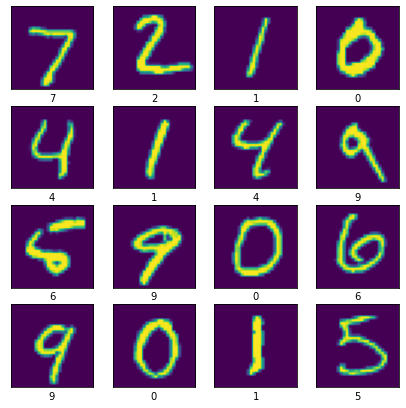

In [0]:
plt.figure(figsize=(7,7))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(test_images_original[i])
    plt.xlabel(predictions[i])
plt.show()